# Vignette: Using the Synderm dataset

In [3]:
from huggingface_hub import get_token
from torch.utils.data import DataLoader
from huggingface_hub import HfApi
import matplotlib.pyplot as plt
import webdataset as wds
from PIL import Image
import pandas as pd
import json
import io
import re

In [4]:
# Set path to root directory of package
%cd ../../../

/workspace/synthetic-derm


/workspace/synthetic-derm/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Dataset Statistics
First, we will show some dataset statistics. Since the dataset is so large (about 1 million images), we have crawled the complete dataset beforehand and generated a csv file at `huggingface/folder_counts.csv`. This lists the total png image count for each combination of disease and synthetic generation type (pretrained/finetuned and inpaint/outpaint/text-to-image)

In [5]:
df = pd.read_csv("huggingface/folder_counts.csv")
df = df.rename(columns={"Image Count": "count", "Folder": "folder"})

# Define the pattern components
extract = {
    "submethods": ["inpaint", "inpaint_outpaint", "text_to_image"],
    "methods": ["inpaint", "text_to_image"],
    "ft": ["finetune", "pretrained"]
}

def match_replace(str, values):
    for value in values:
        if str.endswith(value):
            stop_index = len(str) - len(value) - 1  # Account for underscore
            str = str[0:stop_index]
            return str, value
    return str, None  # Return default if no match found

df["label"] = df["folder"]
for key, values in extract.items():
    result = df["label"].apply(lambda x: match_replace(x, values))
    df["label"] = result.apply(lambda x: x[0])
    df[key] = result.apply(lambda x: x[1])

In [6]:
df.head()

,folder,count,label,submethods,methods,ft
0,acne_finetune_text_to_image_text_to_image,1260,acne,text_to_image,text_to_image,finetune
1,acne_vulgaris_finetune_text_to_image_text_to_i...,2540,acne_vulgaris,text_to_image,text_to_image,finetune
2,actinic_keratosis_finetune_text_to_image_text_...,2940,actinic_keratosis,text_to_image,text_to_image,finetune
3,all_finetune_inpaint_inpaint,35300,all,inpaint,inpaint,finetune
4,all_finetune_inpaint_inpaint_outpaint,35300,all,inpaint_outpaint,inpaint,finetune


In [7]:
def print_table(totals):
    # Display formatted table
    print("-" * 50)
    print(f"{'Label':<40} {'Count':>10}")
    print("-" * 50)
    for label, count in totals.items():
        print(f"{label:<40} {count:>10,}")
    print("-" * 50)

In [8]:
label_totals = df.groupby('label')['count'].sum().sort_values(ascending=False)
print("\nTotal images per label:")
print_table(label_totals)


Total images per label:
--------------------------------------------------
Label                                         Count
--------------------------------------------------
all                                         158,850
psoriasis                                   121,048
basal_cell_carcinoma                         98,594
squamous_cell_carcinoma                      96,410
lichen_planus                                85,380
allergic_contact_dermatitis                  75,212
lupus_erythematosus                          68,164
neutrophilic_dermatoses                      64,344
sarcoidosis                                  63,874
photodermatoses                              61,520
folliculitis                                 49,645
melanoma                                      4,400
mycosis_fungoides                             3,080
actinic_keratosis                             2,940
prurigo_nodularis                             2,650
kaposi_sarcoma                           

In [9]:
label_totals = df.groupby('submethods')['count'].sum().sort_values(ascending=False)
print("\nTotal images per generation type:")
print_table(label_totals)


Total images per generation type:
--------------------------------------------------
Label                                         Count
--------------------------------------------------
text_to_image                               795,021
inpaint                                     105,900
inpaint_outpaint                            105,900
--------------------------------------------------


### Dataset Details

We have developed two version of the 1 million image synthetic derm dataset in [WebDataset](https://github.com/webdataset/webdataset) format. These are:

1) [synthetic-derm-1M](https://huggingface.co/datasets/tbuckley/synthetic-derm-1M): This dataset is organized into .tar shards that contain at most 5,000 images (up to ~2GB). Each shard is named using the format: `shard-{disease-label}-{synthetic-generation-method}-{submethod}-{index}.tar`. An example shard name is `shard-vitiligo-finetune-text-to-image-text-to-image-00000.tar`. This dataset is intended for fine-grained retrieval of particular labels and generation methods.

1) [synthetic-derm-1M-train](https://huggingface.co/datasets/tbuckley/synthetic-derm-1M-train): This dataset is also organized into .tar shards of the same size. However, we group images by generation method, perform a shuffle, and then shard this images. This dataset is better suited to model training since it has already been shuffled. Each shard is named using the format: `shard-{synthetic-generation-method}-{index}.tar`. For model training, the dataset can still be subset to specific labels.

See [WebDataset FAQ](https://github.com/webdataset/webdataset/blob/main/FAQ.md) for many more examples of how to use these two datasets.

Now, we will demonstrate how data can be selected and retrieved from the dataset. Shards contain a flat list of images and metadata (each image has its own metadata file with the same name). This allows the dataset to be serially unpacked and loaded from the cloud, meaning minimal memory and time overhead to use this dataset. The dataset can be loaded in less than a second.

The typical workflow for using this large dataset is:
1) Subset the dataset using the URL for selected labels and methods
2) Iterate over the subset dataset


We will pull all the shard names from the HuggingFace repository and list a few.

In [42]:
api = HfApi()

# Fetch the list of files in the dataset directory
repo_id="tbuckley/synthetic-derm-1M"
files = api.list_repo_files(repo_id=repo_id, repo_type="dataset")

for file in files[0:20]:
    print(file)

.gitattributes
data/shard-acne-finetune-text-to-image-text-to-image-00000.tar
data/shard-acne-vulgaris-finetune-text-to-image-text-to-image-00000.tar
data/shard-actinic-keratosis-finetune-text-to-image-text-to-image-00000.tar
data/shard-all-finetune-inpaint-inpaint-00000.tar
data/shard-all-finetune-inpaint-inpaint-00001.tar
data/shard-all-finetune-inpaint-inpaint-00002.tar
data/shard-all-finetune-inpaint-inpaint-00003.tar
data/shard-all-finetune-inpaint-inpaint-00004.tar
data/shard-all-finetune-inpaint-inpaint-00005.tar
data/shard-all-finetune-inpaint-inpaint-00006.tar
data/shard-all-finetune-inpaint-inpaint-00007.tar
data/shard-all-finetune-inpaint-inpaint-outpaint-00000.tar
data/shard-all-finetune-inpaint-inpaint-outpaint-00001.tar
data/shard-all-finetune-inpaint-inpaint-outpaint-00002.tar
data/shard-all-finetune-inpaint-inpaint-outpaint-00003.tar
data/shard-all-finetune-inpaint-inpaint-outpaint-00004.tar
data/shard-all-finetune-inpaint-inpaint-outpaint-00005.tar
data/shard-all-finet

In [38]:
len(files)

264

#### 1) Subsetting the dataset
First, we will show a few different ways the dataset can be subset. We will start by selecting a few labels of interest, and pulling all instances of these labels that were generated using the `finetune-inpaint` strategy. For simplicity, we will only select the first indexed shard for each label. This means we will pull in at most 5,000 images for each label.

In [32]:
# Change this to a desired directory for caching shards. Shards that are downloaded will populate here
cache_dir = "/n/scratch/users/t/thb286/wds_cache"

In [33]:
# The labels we want to select
labels = [
    "allergic-contact-dermatitis",
    "basal-cell-carcinoma", 
    "folliculitis",
    "lichen-planus",
]
url = "https://huggingface.co/datasets/tbuckley/synthetic-derm-1M/resolve/main/data/shard-{" + ",".join(labels) + "}-finetune-inpaint-inpaint-00000.tar"
dataset = wds.WebDataset(url, cache_dir=cache_dir, shardshuffle=False)

We will unpack and look at the first instance in this dataset. Since WebDataset is a streaming format, we cannot directory index any image -- we must iterate through all images. If you must have random access to images in this dataset, you can use the WebDataset `wids` library.

Keys in the dataset are: dict_keys(['__key__', '__url__', 'json', '__local_path__', 'png'])
Image metadata {'name': 'allergic_contact_dermatitis_finetune_inpaint_inpaint_generations1_00_001d22ff2543f95d2d38c18da0446c84.png', 'md5hash': '001d22ff2543f95d2d38c18da0446c84', 'label': 'allergic-contact-dermatitis', 'method': 'finetune_inpaint', 'submethod': 'inpaint', 'generation_num': '00', 'tag': 'generations1'}


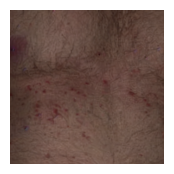

In [34]:
# Print out the first entry in the dataset:
for item in dataset:
    print(f"Keys in the dataset are: {item.keys()}")

    metadata = json.loads(item["json"])
    print(f"Image metadata {metadata}")

    # Decode and display the PNG image
    image = Image.open(io.BytesIO(item["png"]))
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    break

Now, for demonstrating purposes, we will iterate through the entire dataset we have just subset. We will print out the numbers of each class present in this dataset. This will take a few minutes.

In [35]:
class_counts = {label: 0 for label in labels}

for i, item in enumerate(dataset):
    metadata = json.loads(item["json"])

    class_name = metadata["label"]
    class_counts[class_name] += 1

print("\nNumber of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Number of images per class:
allergic-contact-dermatitis: 3580
basal-cell-carcinoma: 4060
folliculitis: 1910
lichen-planus: 4120


Now, for a more advanced example, we will select *all* shards for a list of labels. Since we don't a priori know the number of shards for each label, we will query HuggingFace for a list of all shards. We will then select the shards we need using our list of labels. We will then pass the list of shard URLs to the WebDataset constructor. Finally, we will iterate through the first 10 images in this new dataset and display them **(warning: graphic)**.

In [36]:
labels = [
    "basal-cell-carcinoma",
    "allergic-contact-dermatitis"
]

# Regex pattern to extract shard indices
pattern = re.compile(
    r"data/shard-(?P<label>{})-finetune-text-to-image-text-to-image-(?P<index>\d{{5}})\.tar".format("|".join(labels))
)

available_shards = {label: [] for label in labels}
for file in files:
    match = pattern.match(file)
    if match:
        label = match.group("label")
        index = int(match.group("index"))
        available_shards[label].append(index)

# Function to generate shard URLs for a specific label
def generate_shard_urls(label, indices):
    return [
        f"https://huggingface.co/datasets/{repo_id}/resolve/main/data/shard-{label}-finetune-text-to-image-text-to-image-{i:05d}.tar"
        for i in indices
    ]

all_shard_urls = []
for label, indices in available_shards.items():
    all_shard_urls.extend(generate_shard_urls(label, indices))

# Create a WebDataset
dataset = (
    wds.WebDataset(all_shard_urls, shardshuffle=False)
    .decode("pil")
    .to_tuple("png", "json")
)

print(f"Number of shards collected: {len(all_shard_urls)}")

Number of shards collected: 28


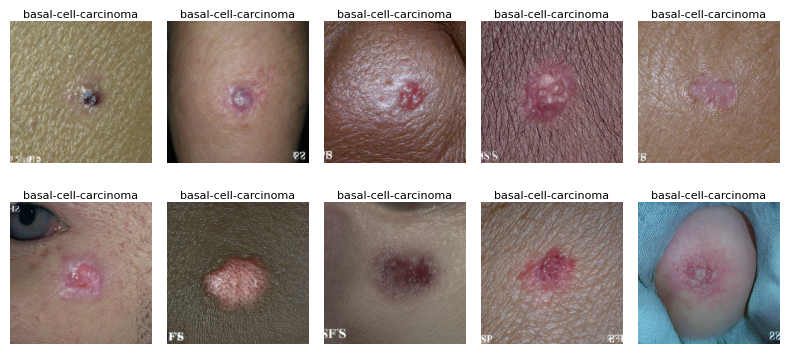

In [37]:
plt.figure(figsize=(8, 4))

for i, item in enumerate(dataset):
    if i >= 10:  
        break

    image, metadata = item

    label = metadata["label"]

    plt.subplot(2, 5, i+1)
    plt.title(label, fontsize=8, pad=2)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

We can also use RandomMix from WebDataset to create a shuffled training dataset from multiple selected labels.

In [1]:
# from webdataset import WebDataset, RandomMix

# ds1 = WebDataset('path_to_shards_A/{00..99}.tar')
# ds2 = WebDataset('path_to_shards_B/{00..99}.tar')
# mix = RandomMix([ds1, ds2], [1.45, 1.0])  # Sampling from ds1 1.45 times more frequently than ds2